<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# [Ateliers: Technologies des données massives](https://github.com/wikistat/Ateliers-Big-Data)

# Text Mining et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

## Introduction

Il s'agit d'une version simplifiée du concours proposé par CDiscount et paru sur le site [datascience.net](https://www.datascience.net/fr/challenge). Les données d'apprentissage sont accessibles sur demande auprès de CDiscount. Les solutions de l'échantillon test du concours ne sont pas et ne seront pas rendues publiques. Un échantillon test est donc construit pour l'usage de ce tutoriel.  L'objectif est de prévoir la catégorie d'un produit à partir de son descriptif. Seule la catégorie principale (1er niveau) est prédite au lieu des trois niveaux demandés dans le concours. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision n'a pas été mise en oeuvre.
* L'exemple est présenté sur un échantillon réduit d'un million de produits au lieu des 15M initiaux
* L'échantillon réduit peut encore l'être puis séparé en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Trois modélisations sont estimées: logistique, arbre, forêt aléatoire.
* Optimiser l'erreur en faisant varier différents paramètres: types et paramètres de vectorisation (TF-IDF), paramètres de la régression logistique (pénalisation l1) et de la forêt aléatoire (nombre d'arbres et nombre de variables aléatoire).

Exécuter finalement le code pour différentes tailles (paramètre  `tauxTot` ci-dessous) de l'échantillon d'apprentissage et comparer les qualités de prévision obtenues. 

Deux échantillons de test ont été mis de côté et seront utilisés dans un prochain calepin (avec pyspark) pour comparer les stratégies.


In [1]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import csv
import warnings

from sklearn.cross_validation import train_test_split

C:\Users\ETIENNE\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

## 1. Importation des données
Définition du répertoir de travail, des noms des différents fichiers utilisés et des variables globales.

Dans un premier temps, il vous faut télécharger les fichiers `Categorie_reduit.csv` et `lucene_stopwords.txt` disponible dans le corpus de données de [wikistat](http://wikistat.fr/).

Une fois téléchargées, placez ces données dans le repertoire de travail de votre choix et préciser la direction de ce repertoir dans la variable `DATA_DIR`

In [3]:
# Répertoire de travail
DATA_DIR = "C:/Users/ETIENNE/Documents/Work/INSA/4A/Projets 4gmm 2018/"

# Nom des fichiers
training_reduit_path = DATA_DIR + "INSA_wefight_data_clean.csv"
# Variable Globale
HEADER_TEST = ['Question','Intent','BlockId', 'Action']
HEADER_TRAIN =['Question','Intent','BlockId', 'Action']

In [4]:
## Si nécessaire (première exécution) chargement de nltk, librairie pour la suppression 
## des mots d'arrêt et la racinisation
## nltk.download()

   ### Read & Split Dataset
   Fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La première méthode créée un DataFrame en lisant entièrement le fichier. Puis elle scinde le DataFrame en deux  grâce à la fonction dédiée de sklearn. 

In [5]:
def split_dataset(input_path, nb_line, tauxValid,columns):
    time_start = time.time()
    data_all = pd.read_csv(input_path,sep=",",names=columns,nrows=nb_line) #cree data frame
    data_all = data_all.fillna("") #remplace les na par " "
    data_train, data_valid = train_test_split(data_all, test_size = tauxValid) # Split arrays or matrices into random train and test subsets
    time_end = time.time()
    print("Split Takes %d s" %(time_end-time_start))
    return data_train, data_valid

nb_line=20000  # part totale extraite du fichier initial ici déjà réduit
tauxValid=0.10 # part totale extraite du fichier initial ici déjà réduit
data_train, data_valid = split_dataset(training_reduit_path, nb_line, tauxValid, HEADER_TRAIN)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
data_train.head(5)

Split Takes 0 s


,Question,Intent,BlockId,Action
4242,ma chimio me donne des nausées,#6-97_TRTEINS_Nausees_Vomissements,59955d76e4b032e0e7890bdf,wiki_cancer
2643,quels sont les effetd secondaires de l'hormono...,#6-31_TRTEINS_Effetsecondaireshormonotherapie,59632c41e4b0a226d067cee4,wiki_cancer
2202,quel est le cout de mon comprimé d'hormonothér...,#2-97_QVDP_ResteACharge,598b43fbe4b03f0d36d746a7,wiki_cancer
3697,"Qu'est ce que la mastectomie totale,",#6-73_TRTEINS_Chirurgie_Mastectomie,59919579e4b0feb288bb04a8,wiki_cancer
3311,"ma bouche est sèche,",#6-58_TRTEINS_Bouche_Seche,59918e6ee4b0feb2888c9bcd,wiki_cancer


## 2. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [6]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords = [unicode(w, "utf-8") for w in open(DATA_DIR+"lucene_stopwords.txt").read().split(",")] #En local

## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Fonction de nettoyage de texte
Fonction qui prend en intrée un texte et retourne le texte nettoyé en appliquant successivement les étapes suivantes: Nettoyage des données HTML, conversion en texte minuscule, encodage uniforme, suppression des caractéres non alpha numérique (ponctuations), suppression des stopwords, racinisation de chaque mot individuellement.

In [7]:
# remarque
#'a b c'.split()
#str.split('a b c')
# both return ['a', 'b', 'c']

In [8]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

### Nettoyage des DataFrames
Applique le nettoyage sur toutes les lignes de la DataFrame

In [9]:
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

In [10]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean = clean_df(data_valid)
data_train_clean = clean_df(data_train)

Start Clean 502 lines
Cleaning time: 0 secondes
Start Clean 4511 lines
Cleaning time: 3 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [11]:
#info sur les données
data_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4511 entries, 0 to 4510
Data columns (total 4 columns):
Question    4511 non-null object
Intent      4511 non-null object
BlockId     4511 non-null object
Action      4511 non-null object
dtypes: object(4)
memory usage: 141.0+ KB


In [12]:
data_train_clean

,Question,Intent,BlockId,Action
0,chimio don nause,#6-97_TRTEINS_Nausees_Vomissements,59955d76e4b032e0e7890bdf,wiki_cancer
1,effetd secondair hormonotherap,#6-31_TRTEINS_Effetsecondaireshormonotherapie,59632c41e4b0a226d067cee4,wiki_cancer
2,cout comprim hormonotherap,#2-97_QVDP_ResteACharge,598b43fbe4b03f0d36d746a7,wiki_cancer
3,mastectom total,#6-73_TRTEINS_Chirurgie_Mastectomie,59919579e4b0feb288bb04a8,wiki_cancer
4,bouch sech,#6-58_TRTEINS_Bouche_Seche,59918e6ee4b0feb2888c9bcd,wiki_cancer
5,peur mettr nu montr cicatric,#2-121_QVDP_Sexualite_Cicatrice,59918978e4b0feb2886aa614,wiki_cancer
6,conseil mucit,#6-53_TRTEINS_Aphtes,59918dbae4b0feb28887a14b,wiki_cancer
7,souffr mucit,#6-53_TRTEINS_Aphtes,59918dbae4b0feb28887a14b,wiki_cancer
8,interet mastectom partiel,#6-73_TRTEINS_Chirurgie_Mastectomie,59919579e4b0feb288bb04a8,wiki_cancer
9,fatigue,#2-64-0_QVDP_Fatigue,59942265e4b068eebf52bb9f,wiki_cancer


In [13]:
#description des données
data_train_clean.describe()

,Question,Intent,BlockId,Action
count,4511,4511,4511,4511
unique,3812,145,133,20
top,rend,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
freq,17,193,193,4244


In [14]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Action"].value_counts())
print("nb Action differente",(data_train["Action"].value_counts()).shape)

wiki_cancer                                          4244
                                                       82
conversation_rappelRendezVous                          76
conversation_rappelRead                                34
conversation_rappelUpdate2                             17
wiki_cancer#                                           14
conversation_FichePatientRead                          11
conversation_FichePatientUpdate                         7
conversation_hist                                       6
conversation_FichePatientWrite:doseTraitement           4
conversation_FichePatientWrite:age                      3
conversation_rappelUpdate                               2
conversation_FichePatientWrite:typeTraitement           2
conversation_FichePatientWrite:rappels                  2
conversation_FichePatientWrite:newsletter               2
action                                                  1
conversation_FichePatientWrite:recevoirTemoignage       1
conversation_F

In [15]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Intent"].value_counts())
print("nb intent differente",(data_train["Intent"].value_counts()).shape)

#6-49_TRTEINS_Peau                             193
#6-97_TRTEINS_Nausees_Vomissements             135
#6-92_TRTEINS_Diarrhee                         129
#2-130_QVDP_Alimentation                       114
#6-53_TRTEINS_Aphtes                           112
#6-90_TRTEINS_Mauvais_Gout                     107
#6-98_TRTEINS_EI_Frequents                     104
#6-60_TRTEINS_PAC                               99
#2-36_QVDP_Alopecie_Pourquoi                    96
#9-2_Informations_cancer                        88
#2-64-0_QVDP_Fatigue                            86
#6-57_TRTEINS_Yeux_Secs                         84
#6-18_TRTEINS_Radiotherapie                     83
conversation_rappel_rendezvous                  76
#6-1_TRTEINS_Chimiotherapie                     73
#2-45_QVDP_Alopecie_Perruque                    72
#6-96_TRTEINS_Perte_Poids                       71
#2-55_QVDP_Douleur                              71
#2-96_QVDP_Social_Priseencharge                 70
#6-58_TRTEINS_Bouche_Seche     

In [17]:
#on enregistre le contenu de la colonne Question dans un fichier csv
#on fait ensuite un wordcloud sur toutes les donnees
description = data_train_clean["Question"]
description.to_csv('Question.csv', sep = ',')

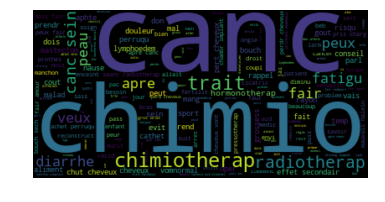

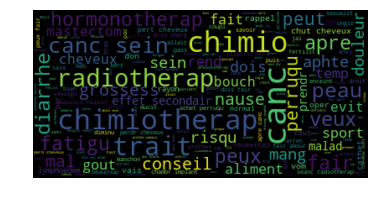

In [18]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open(path.join(DATA_DIR, 'Question.csv')).read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [19]:
# tri par catégorie, on a un data frame pour une catégorie
df = data_train_clean[data_train_clean['Intent'] == '#6-49_TRTEINS_Peau']
df

,Question,Intent,BlockId,Action
13,crem apais,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
21,bouton peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
22,peau irrite,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
25,peau chimiotherap,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
39,effet cutan chimio,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
61,mal main,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
79,crem rich,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
84,crem chimiotherap,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
183,prendr bain,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
197,tach blanch peau,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer


In [20]:
description2 = df
description2.to_csv('Intent.csv', sep = ',')

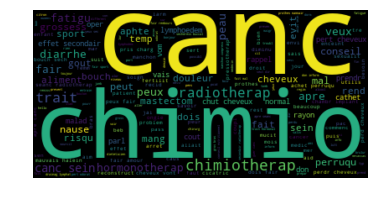

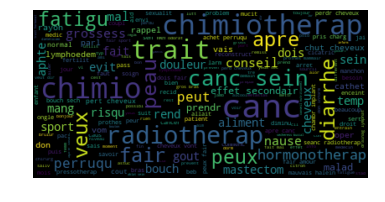

In [21]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open(path.join(DATA_DIR, 'Question.csv')).read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

## 3 Construction des caractéristiques ou *features* (TF-IDF)¶
### Introduction
La vectorisation, c'est-à-dire la construction des caractéristiques à partir de la liste des mots se fait en 2 étapes:
* **Hashage**. Il permet de réduire l'espace des variables (taille du dictionnaire) en un nombre limité et fixé a priori `n_hash` de caractéristiques. Il repose sur la définition d'une fonction de hashage, $h$ qui à un indice $j$ défini dans l'espace des entiers naturels, renvoie un indice $i=h(j)$ dans dans l'espace réduit (1 à n_hash) des caractéristiques. Ainsi le poids de l'indice $i$, du nouvel espace, est l'association de tous les poids d'indice $j$ tels que $i=h(j)$ de l'espace originale. Ici, les poids sont associés d'après la méthode décrite par Weinberger et al. (2009).

N.B. $h$ n'est pas généré aléatoirement. Ainsi pour un même fichier d'apprentissage (ou de test) et pour un même entier n_hash, le résultat de la fonction de hashage est identique

* **TF-IDF**. Le TF-IDF permet de faire ressortir l'importance relative de chaque mot $m$ (ou couples de mots consécutifs) dans un texte-produit ou un descriptif $d$, par rapport à la liste entière des produits. La fonction $TF(m,d)$ compte le nombre d'occurences du mot $m$ dans le descriptif $d$. La fonction $IDF(m)$ mesure l'importance du terme dans l'ensemble des documents ou descriptifs en donnant plus de poids aux termes les moins fréquents car considérés comme les plus discriminants (motivation analogue à celle de la métrique du chi2 en anamlyse des correspondance). $IDF(m,l)=\log\frac{D}{f(m)}$ où $D$ est le nombre de documents, la taille de l'échantillon d'apprentissage, et $f(m)$ le nombre de documents ou descriptifs contenant le mot $m$. La nouvelle variable ou *features* est $V_m(l)=TF(m,l)\times IDF(m,l)$.

* Comme pour les transformations des variables quantitatives (centrage, réduction), la même transformation c'est-à-dire les mêmes pondérations, est calculée sur l'achantillon d'apprentissage et appliquée à celui de test.

### Fonction de Vectorisation

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import FeatureHasher

##### Vectorisation avec tf et idf

In [23]:
np.shape(data_train_clean["Question"])

(4511L,)

In [56]:
stop_words = nltk.corpus.stopwords.words('french')
question = data_train_clean["Question"] #on va travailler que sur la colonne des questions
vec = TfidfVectorizer(
            min_df = 1, #on prend tous les mots
            stop_words =stop_words,
            smooth_idf=True,
            norm='l2',
            sublinear_tf=True,
            use_idf=False, #tf avec idf
            ngram_range=(1,1)) # BIEN REFLECHIR COMMENT L UTILISER
tfidf =  vec.fit_transform(question)

Le n gram range va delimiter le nombre de mot que l'on prend dans une ligne.
Remarque, si on a ngram(1,3) sur la phrase "ablation des parties" on a la sortie "ablation" "ablation des" "ablations des parties" Les mots seront ordonné en fonction de leur tfidf

In [ ]:
tfidf

In [57]:
print(np.shape(tfidf)) # tf idf ligne = question colonne = mot qu'on garde
print(vec.get_feature_names())
#len(vec.get_feature_names())

(4511, 1977)
[u'abandonne', u'abdominal', u'abim', u'abime', u'ablat', u'abord', u'absenc', u'absolu', u'acce', u'acced', u'accept', u'accompagn', u'accord', u'accouch', u'accueil', u'achat', u'achet', u'aci', u'acne', u'actif', u'action', u'activit', u'acuit', u'adapt', u'adapte', u'adenofibrom', u'adjuv', u'administr', u'ado', u'adorm', u'adress', u'aer', u'affaibl', u'affect', u'age', u'aggrav', u'agit', u'agueus', u'aid', u'aigreur', u'aiguill', u'aill', u'ailleur', u'aim', u'air', u'aissel', u'aitr', u'ajout', u'alait', u'alcool', u'ald', u'aliment', u'alimentair', u'alitos', u'allait', u'allaitemenm', u'allaitementgest', u'allant', u'aller', u'allerg', u'allez', u'alopec', u'alopecie_casquerefriger', u'alopecie_perruqu', u'alor', u'alter', u'altere', u'aluminium', u'alzheim', u'ambul', u'ambulatoir', u'amelior', u'ami', u'amical', u'amis', u'amour', u'an', u'anastrozol', u'ancer', u'ancien', u'and', u'andocrinien', u'androgen', u'anem', u'anesthes', u'angoiss', u'angoissent', u'a

In [58]:
#dimension de la matrice sparse des poids
np.shape(tfidf)

(4511, 1977)

In [59]:
# définition de la commande
X = tfidf
nom = vec.get_feature_names() #on recupere le nom des variables
svd = TruncatedSVD(n_components=30, n_iter=40, random_state=42)
svd.fit(X)
#variance expliquee
print(svd.explained_variance_ratio_) 
print (" ")
#valeurs singuliere
print(svd.singular_values_)

[ 0.03105747  0.01441752  0.01701604  0.01615593  0.01508899  0.01502083
  0.01414497  0.01324065  0.01267686  0.0105522   0.00939744  0.00893016
  0.00889585  0.00782813  0.00828063  0.0079094   0.00780776  0.00776573
  0.00769416  0.00735828  0.00690905  0.00683806  0.00653902  0.00632521
  0.00580481  0.00559837  0.00535167  0.00543163  0.00539831  0.00525598]
 
[ 12.80575933   9.36212772   8.70011505   8.49997327   8.24567142
   8.17837651   7.93334864   7.70885246   7.51254643   6.8510651
   6.4692117    6.37849394   6.31320072   6.1073262    6.07156925
   5.93423719   5.88871928   5.8715945    5.84415433   5.74297995
   5.5411494    5.50940522   5.38761781   5.30201806   5.07794779
   4.987052     4.91738441   4.91050526   4.89848466   4.83648182]


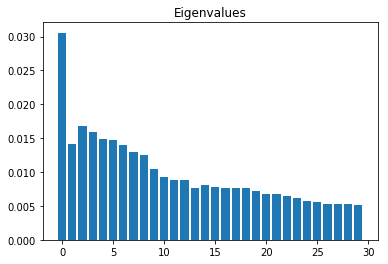

In [60]:
# Eboulis des valeurs propres
plt.figure()
abscisse = np.arange(30)
plt.bar(abscisse,svd.explained_variance_)
plt.title("Eigenvalues")
plt.show()

##### Question : comment chopper le nom des variables, vu qu'on a vectorisé notre data frame ?

Deux variables tirent l'informations, si on couple avec le graphe wordcloud on peut penser que ce sont cancer et chimio

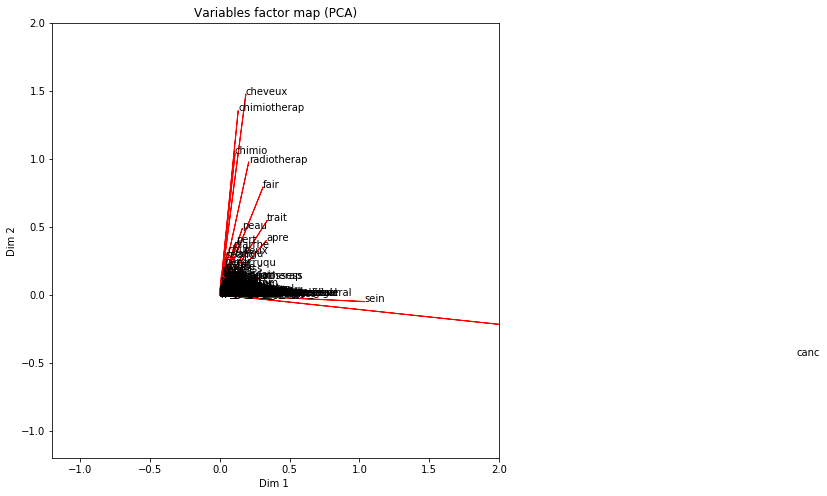

In [61]:
# composantes principales
C = svd.fit(X).transform(X)

#la svd affiche l'acp centree reduite
#on multiplie toutes nos composantes principales par une constante pour avoir des graphes plus visibles
coord1=svd.components_[0]*np.sqrt(svd.explained_variance_[0])*25
coord2=svd.components_[1]*np.sqrt(svd.explained_variance_[1])*25
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
nom
for i, j,nom in zip(coord1,coord2,nom):
    plt.text(i, j,nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,2,-1.2,2))
plt.title("Variables factor map (PCA)")
ax.set_xlabel('Dim 1 ')
ax.set_ylabel('Dim 2')
plt.show()

##### Vectorisation avec tf sansidf

In [ ]:
# Eboulis des valeurs propres
plt.figure()
abscisse = np.arange(30)
plt.bar(abscisse,svd.explained_variance_)
plt.title("Eigenvalues")
plt.show()